# Simulated bandwidth limited thermal noise + sine wave fun

If we take a measurement of the gain of a system can we generate some bandwidth limited thermal noise and compare this to measured signals.



In [1]:
from PyScopeTools import PyScopeTools as pst
from PyFFTTools import PyFFTTools as pft
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.signal import savgol_filter
import matplotlib.style
import matplotlib as mpl
import math
import scipy.fftpack
from scipy.signal import butter,filtfilt
from scipy.fft import fft, ifft  # Import the fft and inverse fft functions

# Import the curve_fit function
from scipy.optimize import curve_fit

#Set default figure size
mpl.rcParams['figure.figsize'] = [12.0, 8.0]
mpl.rcParams["legend.frameon"] = False
mpl.rcParams.update({'font.size': 22})

In [2]:
arrNoise = np.loadtxt("caldata/LMNOCOUPLERFNOISE.CSV",delimiter=",", dtype=float,skiprows=3)
arrSine = np.loadtxt("caldata/LMNOCOUPLERSINE.CSV",delimiter=",", dtype=float,skiprows=3)

In [3]:
#Now we can get some frequency bins, which we will get by defining some time sampling
N=100000
dt=(1/20e9) #20GSa/s
fs=1/dt
#dt=(1/10e9) #20GSa/s
t=np.linspace(0,dt*(N-1),N)
xf = pft.getFrequencyBins(N,dt)
print("t.shape",t.shape)
print("xf.shape",xf.shape)

t.shape (100000,)
xf.shape (50001,)


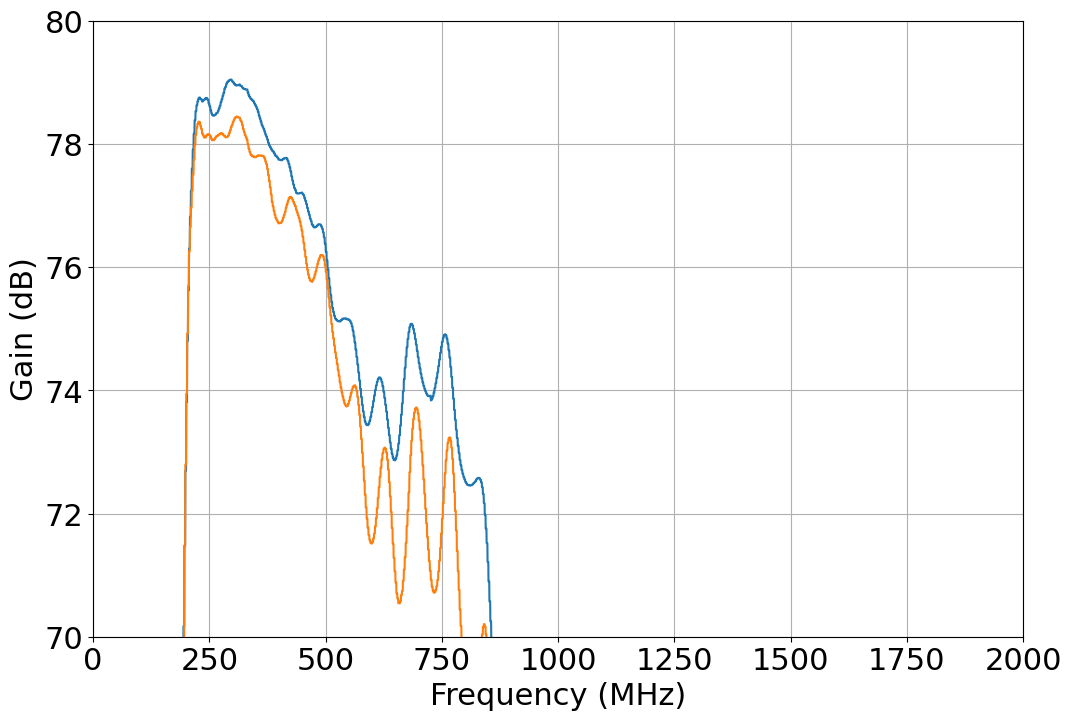

In [4]:
gainNoise=pft.convertFrequencyBinning(arrNoise,xf) +63 #For 60dB of attenuation in VNA measurement + 3dB since both halfs of spliter contribute
gainSine=pft.convertFrequencyBinning(arrSine,xf) +63 #For 60dB of attenuation in VNA measurement + 3dB since both halfs of spliter contribute

fig, ax = plt.subplots()
ax.plot(xf/1e6,gainNoise)
ax.plot(xf/1e6,gainSine)
ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel("Gain (dB)")
ax.set_xlim([0,2000])
ax.set_ylim([70,80])
ax.grid()

(50001,)
[-0.10452001 -0.0871075  -0.06772401 -0.04663978 -0.02418675 -0.0008806
  0.02267027  0.04572326  0.06746514  0.0870324 ]
0.1548736422897531


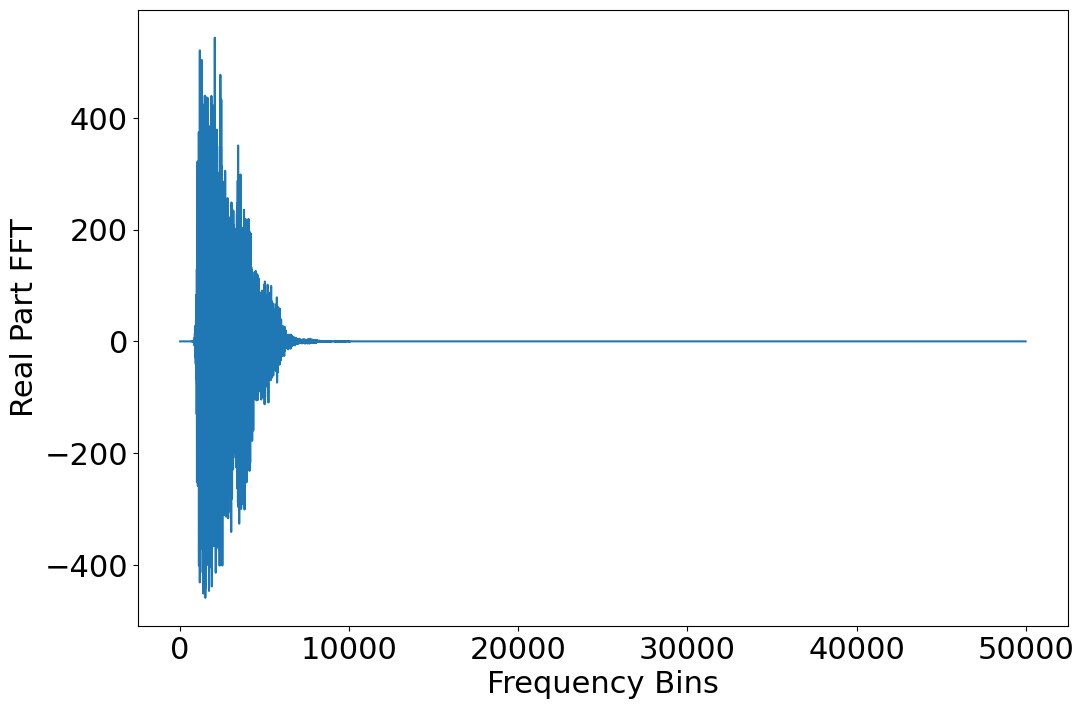

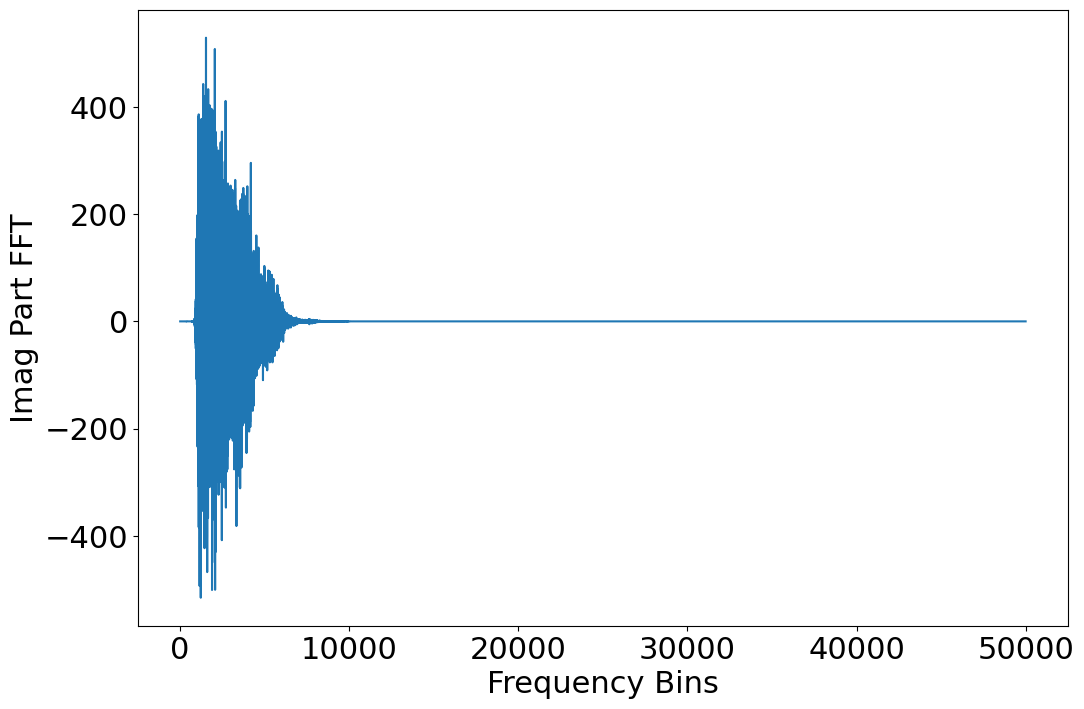

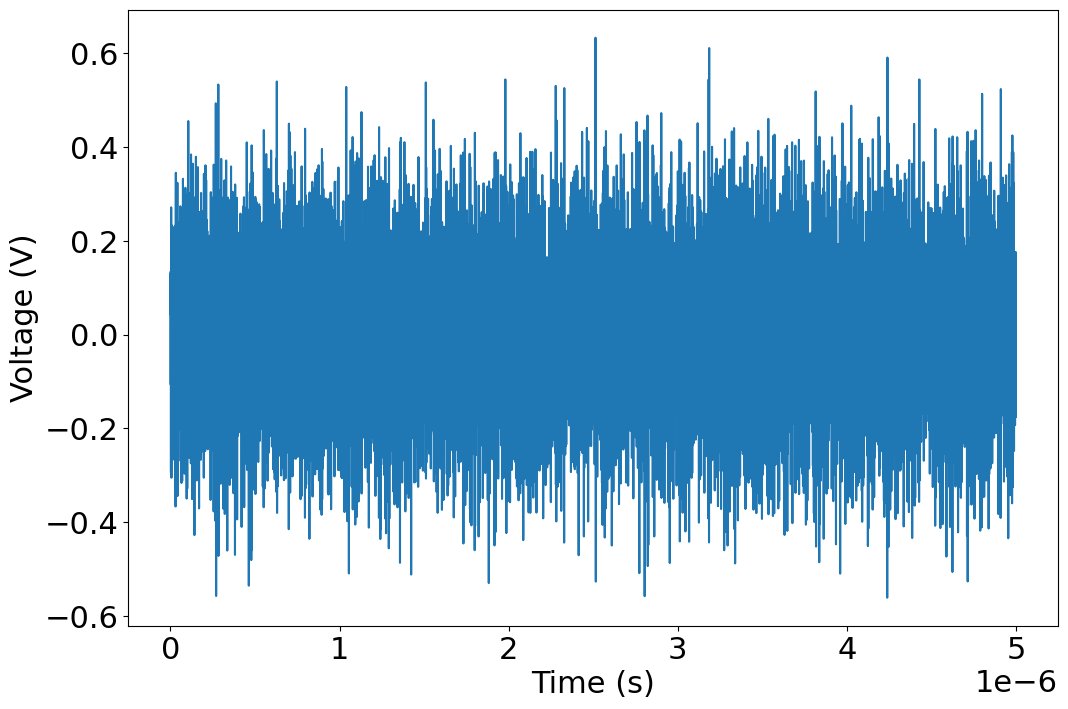

In [5]:
from scipy.fft import rfft, irfft  # Import the fft and inverse fft functions

fftVals=pft.generateThermalNoiseRFFT(xf,gainNoise,T=292,R=50)
print(fftVals.shape)
vals=irfft(fftVals)

print(vals[0:10])

fig, ax = plt.subplots()
ax.plot(np.arange(fftVals.shape[0]),np.real(fftVals))
ax.set_ylabel("Real Part FFT")
ax.set_xlabel("Frequency Bins")


fig, ax = plt.subplots()
ax.plot(np.arange(fftVals.shape[0]),np.imag(fftVals))
ax.set_ylabel("Imag Part FFT")
ax.set_xlabel("Frequency Bins")


fig, ax = plt.subplots()
ax.plot(t,vals)
ax.set_ylabel("Voltage (V)")
ax.set_xlabel("Time (s)")

print(np.std(vals))


std(vals) 0.1548736422897531


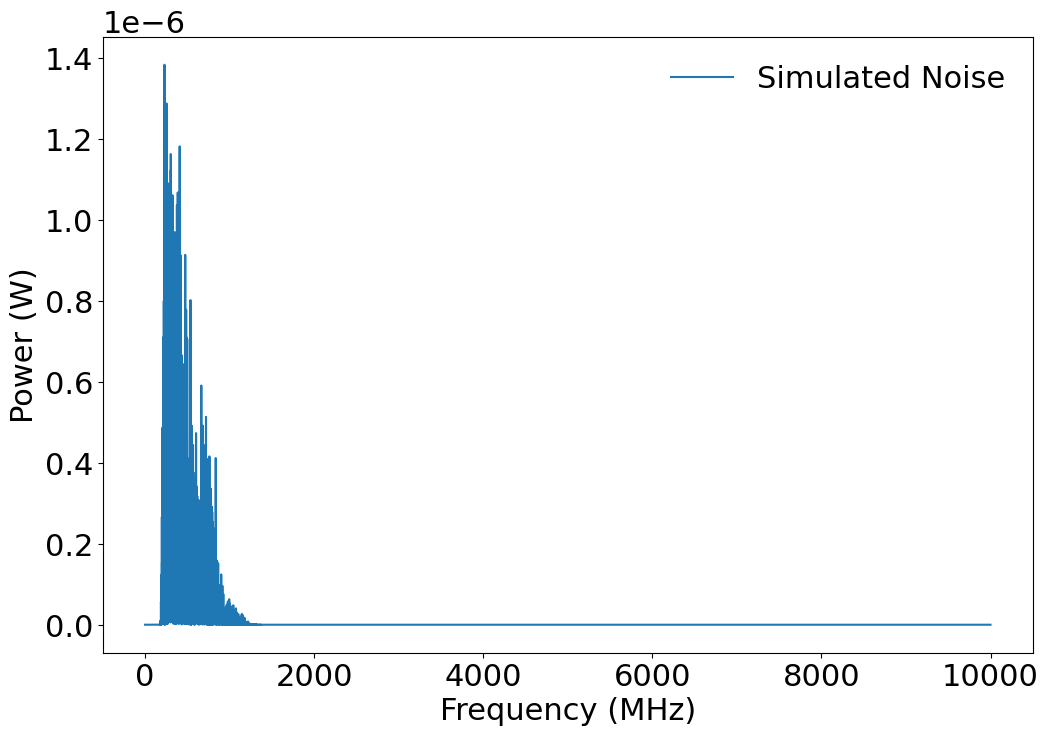

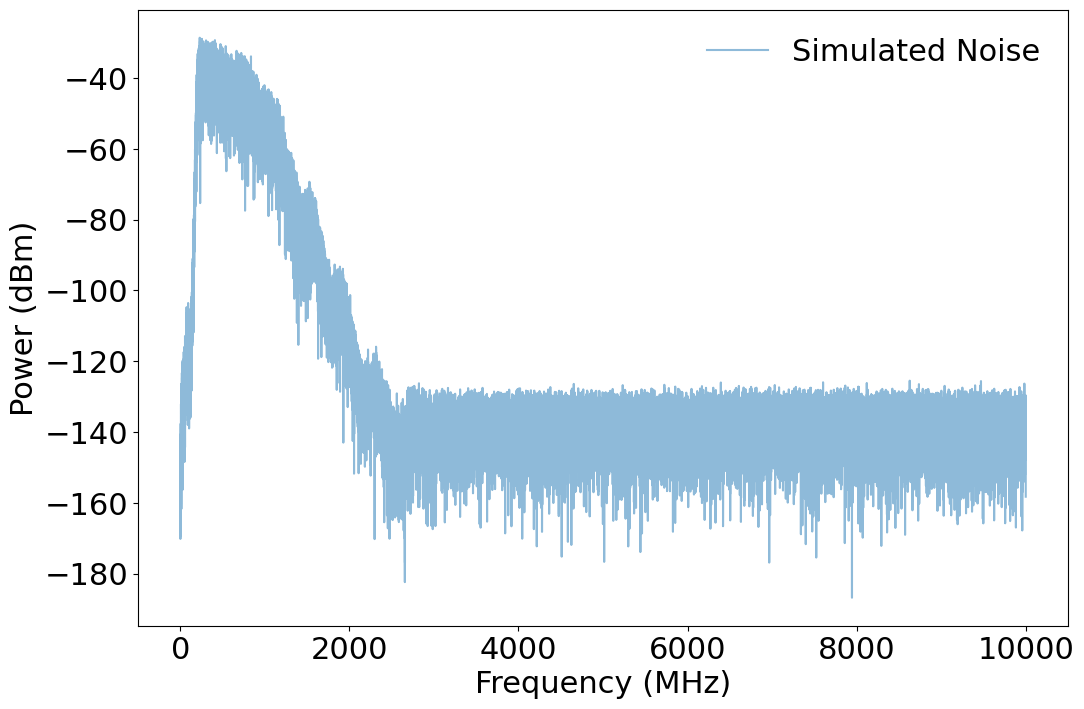

In [6]:
ySim=fft(vals)

#Plot the frequency around the centre frequency bin
fig,ax = plt.subplots()
ax.plot(xf/1e6,pft.convertFFTToPower(ySim,50),label="Simulated Noise")  #1e6 to convert to MHz
ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel("Power (W)")
#ax.set_xlim([0,2e3])
ax.legend()


fig,ax = plt.subplots()
ax.plot(xf/1e6,pft.convertFFTTodBm(ySim),label="Simulated Noise",alpha=0.5)
#ax.plot(xf,gainNoise,label="Measured Gain",alpha=0.5)
ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel("Power (dBm)")
#ax.set_yscale('log')
low,high=ax.get_ylim()
#ax.set_ylim([-100,high])
#ax.set_xlim([0,2e3])
ax.legend()


print("std(vals)",np.std(vals))
noiseStd=np.std(vals)

## Now lets add some signal!!

So here we have defined our prescription for generating noise. Our next steps are to add a sine wave and see how well we can extract it from the noise.

In [7]:
def getSine(t,w,A,phi):
    """Function to return a simple sine 

    Args:
        t: The array of times
        w: The angular frequency
        A: The amplitude
        phi: The phase at t=0
 
     Returns:
        The sine values as an array

    """
    return A*np.sin((w*t)+phi)

def generateNoise(t,gainNoise):
    xf = pft.getFrequencyBins(len(t),t[1]-t[0])
    rfftVals=pft.generateThermalNoiseRFFT(xf,gainNoise,T=292,R=50)
    noiseVals=irfft(rfftVals)
    return noiseVals
    
    
    
def generateNoiseAndFit(tSine,vSine,gainNoise,numWaveforms,thisFreq,thisAmp):
    xf = pft.getFrequencyBins(len(tSine),tSine[1]-tSine[0])
    guessPhase=0
    guessOmega=thisFreq*2*math.pi
    guessAmp=thisAmp
    
    omegas=np.zeros(numWaveforms)
    freqs=np.zeros(numWaveforms)
    amps=np.zeros(numWaveforms)
    phases=np.zeros(numWaveforms)
    failCount=0

    
    for i in range(numWaveforms):
        rfftVals=pft.generateThermalNoiseRFFT(xf,gainNoise,T=292,R=50)
        noiseVals=irfft(rfftVals)
        try:
            parameters, covariance = curve_fit(getSine, tSine, vSine+noiseVals,p0=[guessOmega,guessAmp,guessPhase])
        except:
            print("Failure ",failCount," to fit",i)
            failCount=failCount+1
            if(failCount>10):
                raise Exception("Sorry I've given up after failing to fit",failCount)
        omegas[i]=parameters[0]
        freqs[i]=parameters[0]/(2*math.pi)
        amps[i]=parameters[1]
        phases[i]=parameters[2]
    return omegas,freqs,amps,phases

[-0.08165977 -0.07929523 -0.07277125 -0.06212091 -0.04769727 -0.03020458
 -0.01059893  0.00996808  0.03018274  0.04882901]
[1.88495395e+09 9.89260930e-02 1.33797587e-01]
[[ 2.41231359e+07  9.04588538e-04 -6.03080336e+01]
 [ 9.04588538e-04  4.91816169e-07 -2.26075292e-09]
 [-6.03080336e+01 -2.26075292e-09  2.01026506e-04]]


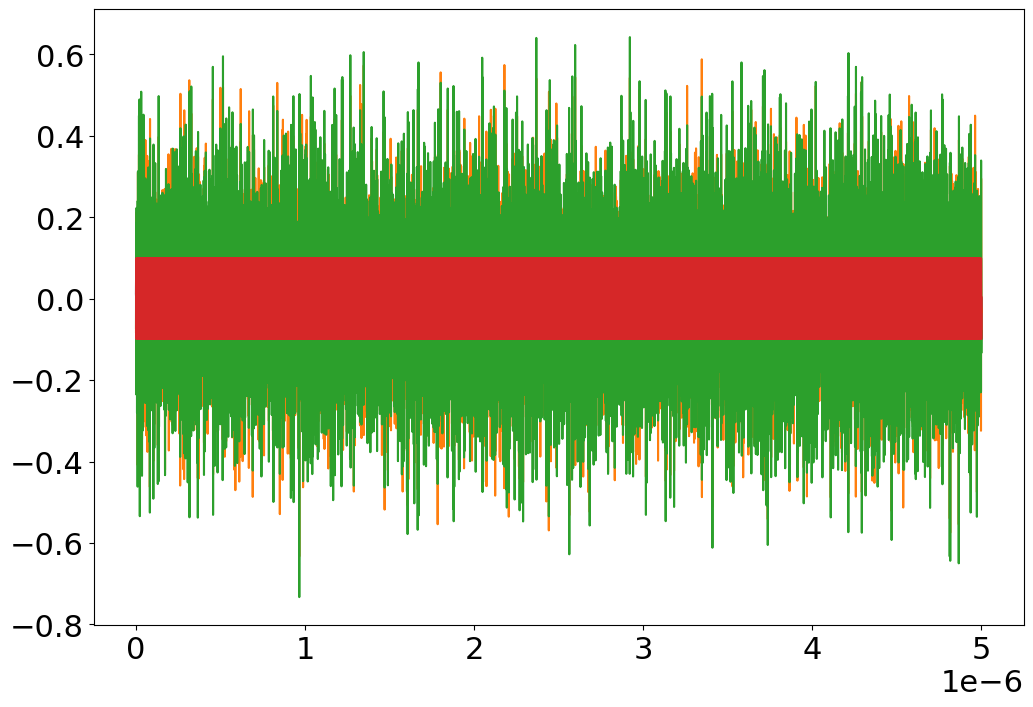

In [8]:
thisFreq=300e6
thisAmp=0.1
grSine=getSine(t,thisFreq*2*math.pi,thisAmp,0.1)
npsOmega,npsFreq,npsAmp,npsPhase=generateNoiseAndFit(t,grSine,gainNoise,1000,thisFreq,thisAmp)

rfftVals=pft.generateThermalNoiseRFFT(xf,gainNoise,T=292,R=50)
noiseVals=irfft(rfftVals)
print(noiseVals[0:10])
fig,ax = plt.subplots()
ax.plot(t,grSine)
ax.plot(t,noiseVals)
ax.plot(t,grSine+noiseVals)
parameters, covariance = curve_fit(getSine, t, grSine+noiseVals,p0=[2*math.pi*thisFreq,thisAmp,0])
print(parameters)
print(covariance)
#print(np.random.normal(loc=0,scale=np.array([1,1,1])))
#print(np.random.normal(loc=0,scale=np.array([1,1,1])))


ax.plot(t,getSine(t,*parameters))

Noisy Freq std 3970.4100284762303 Hz
Noisy Mean Amp 0.09995864609968955 V 0.0001999172921993791


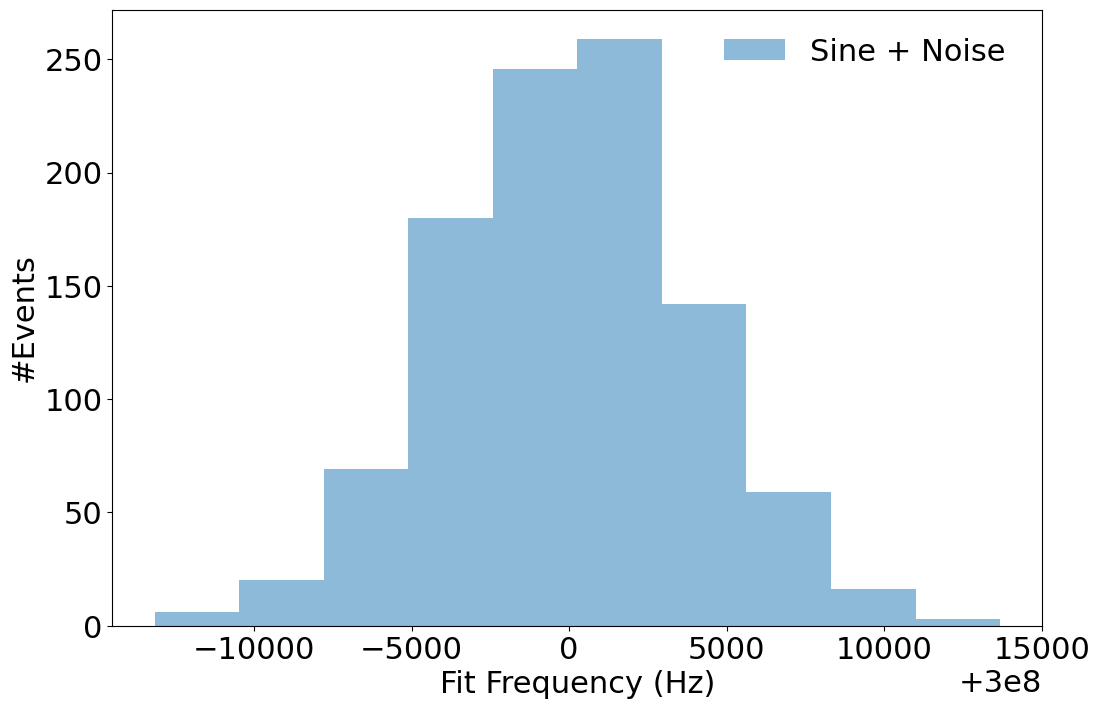

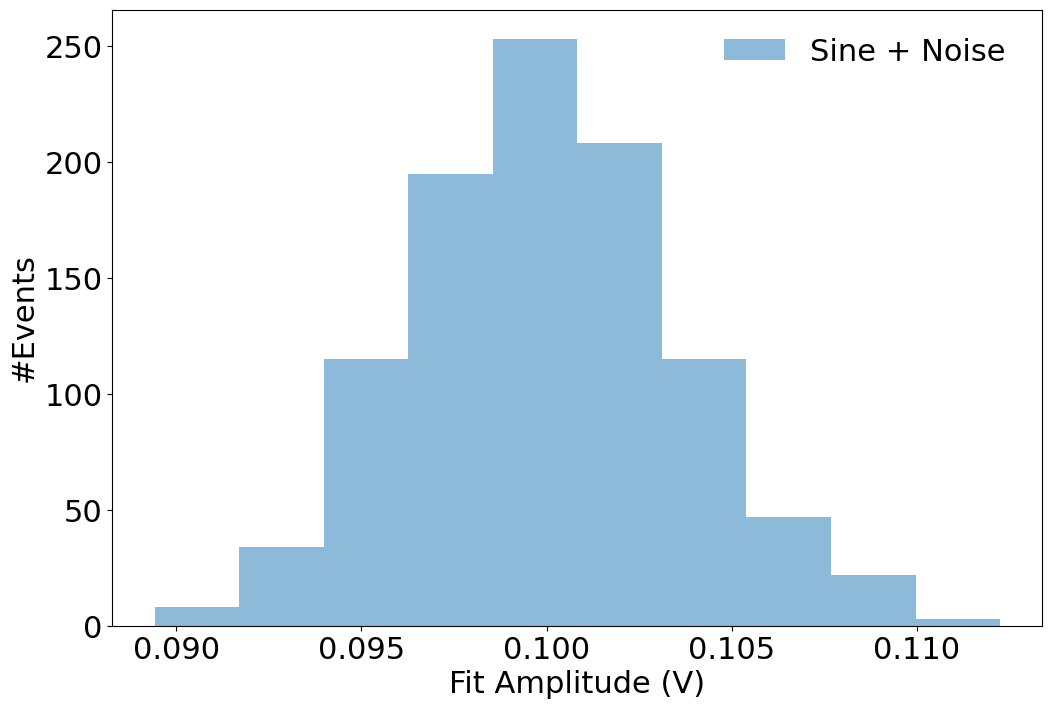

In [9]:
fig,ax = plt.subplots()
ax.hist(npsFreq,alpha=0.5,label="Sine + Noise ")
ax.set_xlabel("Fit Frequency (Hz)")
ax.set_ylabel("#Events")
ax.legend()
print("Noisy Freq std",np.std(npsFreq),"Hz")

fig,ax = plt.subplots()
ax.hist(np.abs(npsAmp),alpha=0.5,label="Sine + Noise ")
ax.set_xlabel("Fit Amplitude (V)")
ax.set_ylabel("#Events")
ax.legend()
print("Noisy Mean Amp",np.mean(npsAmp),"V",np.mean(npsAmp)/500)


In [10]:

ampList = np.linspace(0.1,1,10)

npsFitAmpMeanList=[]
npsFitAmpStdList=[]
npsStdList=[]

for thisAmp in ampList:
    print("Starting",thisFreq,thisAmp)
    thisFreq=300e6
    grSine=getSine(t,thisFreq*2*math.pi,thisAmp,0.1)
    npsOmega,npsFreq,npsAmp,npsPhase=generateNoiseAndFit(t,grSine,gainNoise,1000,thisFreq,thisAmp)
    npsStdList.append(np.std(npsFreq))
    npsFitAmpMeanList.append(np.mean(npsAmp))
    npsFitAmpStdList.append(np.std(npsAmp))
    

Starting 300000000.0 0.1
Starting 300000000.0 0.2
Starting 300000000.0 0.30000000000000004
Starting 300000000.0 0.4
Starting 300000000.0 0.5
Starting 300000000.0 0.6
Starting 300000000.0 0.7000000000000001
Starting 300000000.0 0.8
Starting 300000000.0 0.9
Starting 300000000.0 1.0


Text(0, 0.5, 'Meas. over Est. Freq. Std ')

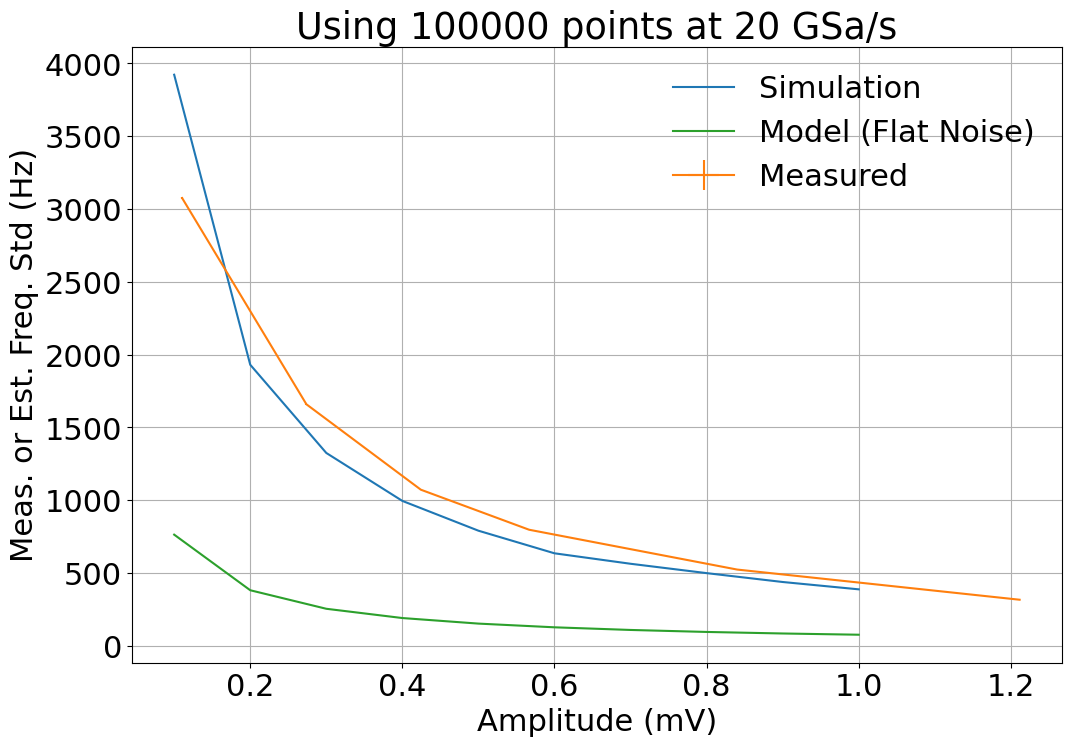

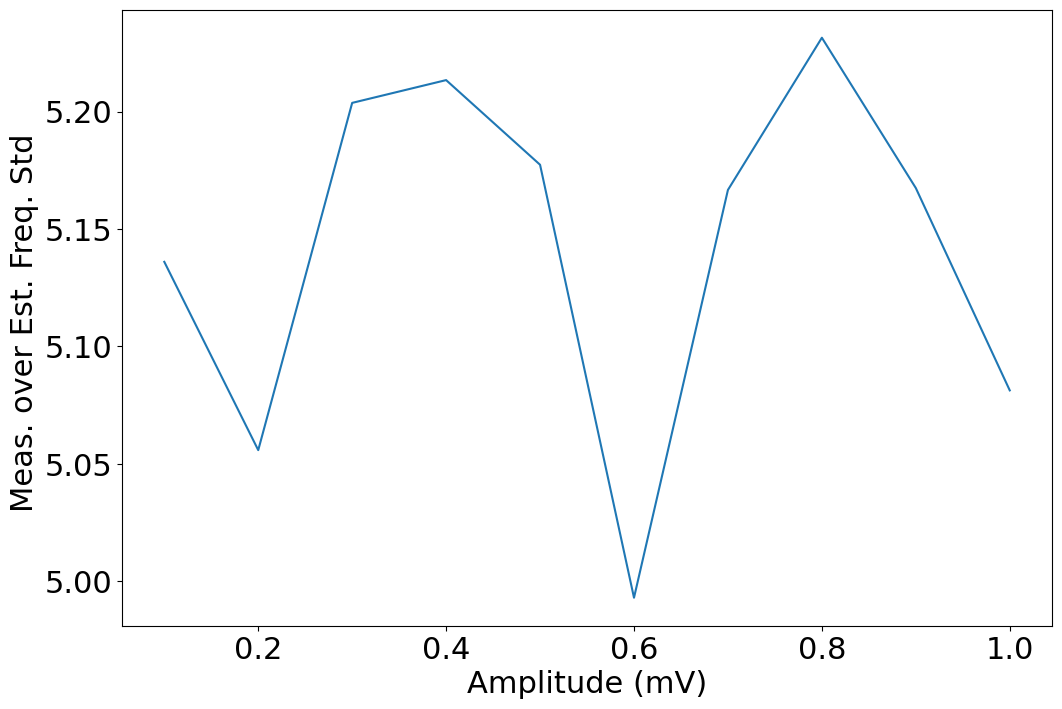

In [11]:

def getEstFreqVariance(snrp,samplingRate,observationTime):
    return 3 / (math.pi**2 *(snrp*(samplingRate*observationTime**3 - observationTime/samplingRate)))

snrp=ampList**2 / (2*noiseStd**2)
samplingRate=1./ (t[1]-t[0])
obTime=t[-1]-t[0]

#amp2=np.array([50, 100, 150, 200, 300, 500])
amp2=np.array([0.11047753600335125, 0.27383510815748524, 0.42430912372232615, 0.5666547073968868, 0.8401844695350758, 1.2115409305639537]
)
ampErr=np.array([0.08860300011175086, 0.06375075019899823, 0.027269640771892752, 0.00403857455612392, 0.0037037200223136437, 0.002026836148068199])/np.sqrt(100000)
mod2=np.array([740.96273267, 298.93806359, 192.92476263, 144.46140817,  97.43067141, 67.56662933])
meas=np.array([3075.34433119, 1659.13399686, 1072.37595164,  797.41231128,  523.89373019,316.70178646])
measErr=np.array([6.87671336, 3.70995495, 2.39791751, 1.78307705, 1.17146785, 0.70817026])

fig,ax = plt.subplots()
ax.plot(ampList,npsStdList,label="Simulation")
ax.errorbar(amp2,meas,xerr=ampErr,yerr=measErr,label="Measured")
ax.plot(ampList,np.sqrt(getEstFreqVariance(snrp,samplingRate,obTime)),label='Model (Flat Noise)')
ax.set_xlabel("Amplitude (mV)")
ax.set_ylabel("Meas. or Est. Freq. Std (Hz)")
ax.legend()
ax.set_title("Using "+str(N)+" points at "+str(int(np.round(fs/1e9,0)))+" GSa/s")
ax.grid()


fig,ax = plt.subplots()
ax.plot(ampList,npsStdList/np.sqrt(getEstFreqVariance(snrp,samplingRate,obTime)))
ax.set_xlabel("Amplitude (mV)")
ax.set_ylabel("Meas. over Est. Freq. Std ")



/var/folders/tt/td83hb5118g0l77wvd_87jfr0000gn/T/ipykernel_42942/2468893016.py:16: RuntimeWarning: divide by zero encountered in divide
  return 1./(1+np.power(fc/xf,2*order))
/var/folders/tt/td83hb5118g0l77wvd_87jfr0000gn/T/ipykernel_42942/2468893016.py:23: RuntimeWarning: divide by zero encountered in log10
  return 20*np.log10(gain)
/var/folders/tt/td83hb5118g0l77wvd_87jfr0000gn/T/ipykernel_42942/2468893016.py:16: RuntimeWarning: overflow encountered in power
  return 1./(1+np.power(fc/xf,2*order))
/var/folders/tt/td83hb5118g0l77wvd_87jfr0000gn/T/ipykernel_42942/2468893016.py:12: RuntimeWarning: overflow encountered in power
  return 1./(1+np.power(xf/fc,2*order))


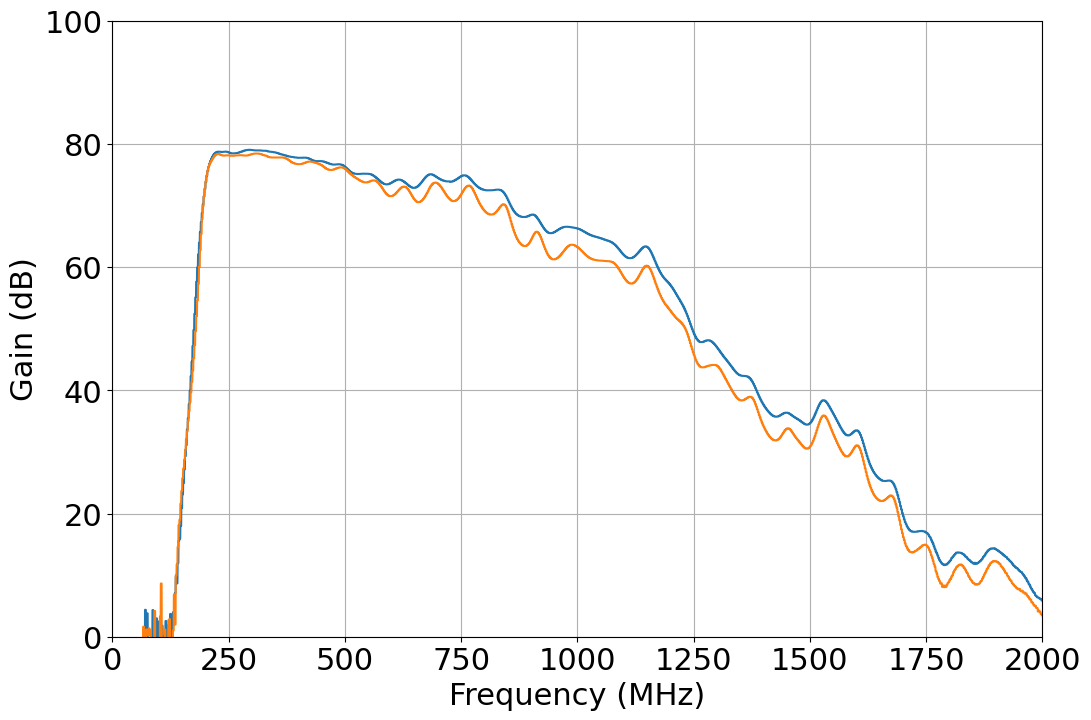

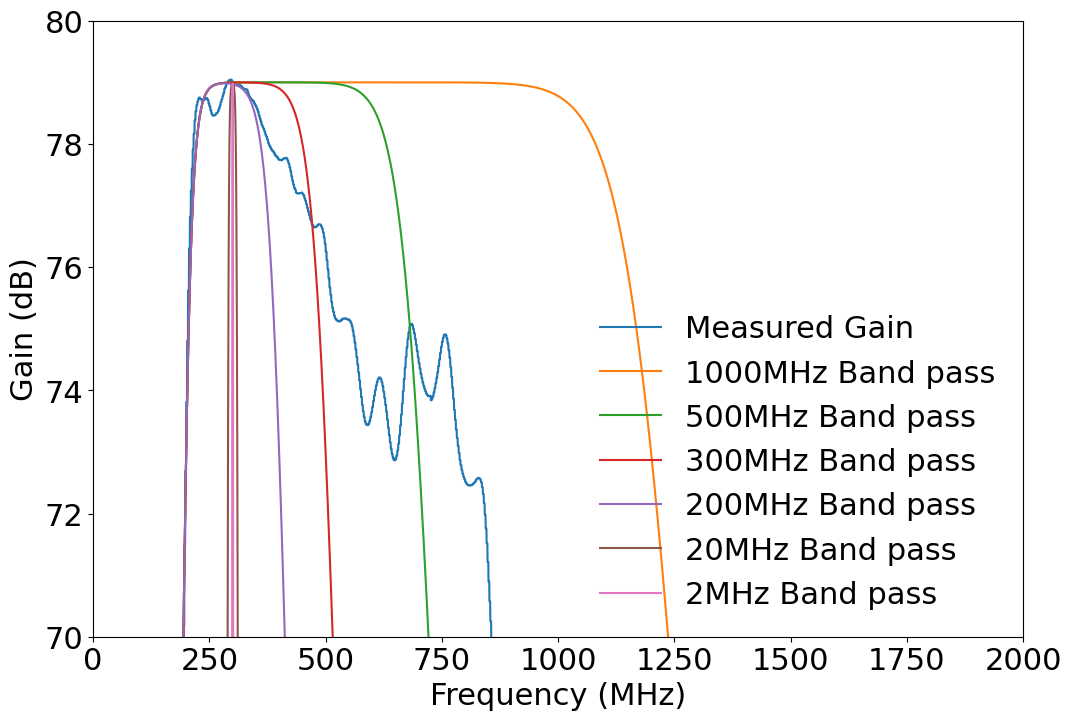

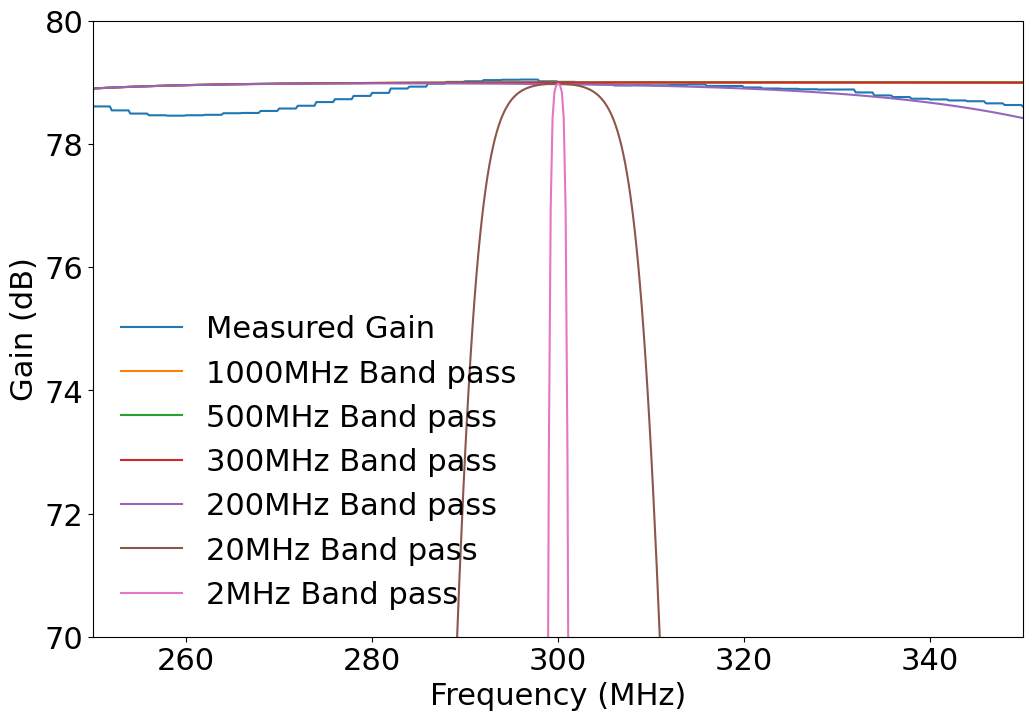

In [12]:

fig, ax = plt.subplots()
ax.plot(xf/1e6,gainNoise)
ax.plot(xf/1e6,gainSine)
ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel("Gain (dB)")
ax.set_xlim([0,2000])
ax.set_ylim([0,100])
ax.grid()


def butterworthLowPass(xf,fc,order):
    return 1./(1+np.power(xf/fc,2*order))


def butterworthHighPass(xf,fc,order):
    return 1./(1+np.power(fc/xf,2*order))


def butterworthBandPass(xf,low,high,order,gain=1):
    return gain*butterworthHighPass(xf,low,order)*butterworthLowPass(xf,high,order)

def connvertGainTodB(gain):
    return 20*np.log10(gain)


def connvertdBToGain(dB):
    return np.power(10,dB/20)

fig, ax = plt.subplots()
#ax.plot(xf/1e6,butterworthLowPass(xf,500e6,9))
#ax.plot(xf/1e6,butterworthHighPass(xf,500e6,9))
ax.plot(xf/1e6,gainNoise,label="Measured Gain")
ax.plot(xf/1e6,connvertGainTodB(butterworthBandPass(xf,200e6,1200e6,10,connvertdBToGain(79))),label="1000MHz Band pass")
ax.plot(xf/1e6,connvertGainTodB(butterworthBandPass(xf,200e6,700e6,10,connvertdBToGain(79))),label="500MHz Band pass")
ax.plot(xf/1e6,connvertGainTodB(butterworthBandPass(xf,200e6,500e6,10,connvertdBToGain(79))),label="300MHz Band pass")
ax.plot(xf/1e6,connvertGainTodB(butterworthBandPass(xf,200e6,400e6,10,connvertdBToGain(79))),label="200MHz Band pass")
ax.plot(xf/1e6,connvertGainTodB(butterworthBandPass(xf,290e6,310e6,100,connvertdBToGain(79))),label="20MHz Band pass")
ax.plot(xf/1e6,connvertGainTodB(butterworthBandPass(xf,299e6,301e6,1000,connvertdBToGain(79))),label="2MHz Band pass")

ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel("Gain (dB)")
ax.set_xlim([0,2000])
ax.set_ylim([70,80])
ax.legend()


fig, ax = plt.subplots()
#ax.plot(xf/1e6,butterworthLowPass(xf,500e6,9))
#ax.plot(xf/1e6,butterworthHighPass(xf,500e6,9))
ax.plot(xf/1e6,gainNoise,label="Measured Gain")
ax.plot(xf/1e6,connvertGainTodB(butterworthBandPass(xf,200e6,1200e6,10,connvertdBToGain(79))),label="1000MHz Band pass")
ax.plot(xf/1e6,connvertGainTodB(butterworthBandPass(xf,200e6,700e6,10,connvertdBToGain(79))),label="500MHz Band pass")
ax.plot(xf/1e6,connvertGainTodB(butterworthBandPass(xf,200e6,500e6,10,connvertdBToGain(79))),label="300MHz Band pass")
ax.plot(xf/1e6,connvertGainTodB(butterworthBandPass(xf,200e6,400e6,10,connvertdBToGain(79))),label="200MHz Band pass")
ax.plot(xf/1e6,connvertGainTodB(butterworthBandPass(xf,290e6,310e6,100,connvertdBToGain(79))),label="20MHz Band pass")
ax.plot(xf/1e6,connvertGainTodB(butterworthBandPass(xf,299e6,301e6,1000,connvertdBToGain(79))),label="2MHz Band pass")

ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel("Gain (dB)")
ax.set_xlim([250,350])
ax.set_ylim([70,80])
ax.legend()



In [13]:
ampList = np.linspace(0.1,1,10)
scaledAmpList=ampList*np.power(10,-79/20)
print(scaledAmpList)
print(ampList/scaledAmpList)

def find_nearest_index(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    else:
        return idx

def doSingleLoopForNetwork(gainNetwork,ampList,thisFreq,numWaves=1000):
    #Now some hideous code because I'm too lazy too chaneg the amplitude of the sine wave properly
    xf = pft.getFrequencyBins(len(t),t[1]-t[0])
    idx= find_nearest_index(xf,thisFreq)
    thisGaindB=gainNetwork[idx]
    voltScale=np.power(10,thisGaindB/20)
    
    netFitAmpMeanList=[]
    netFitAmpStdList=[]
    netFitFreqMeanList=[]
    netFitFreqStdList=[]
    for rawAmp in ampList:
        thisAmp=rawAmp*voltScale
        print("Starting",thisFreq,thisAmp,thisAmp)
        grSine=getSine(t,thisFreq*2*math.pi,thisAmp,0)
        netOmega,netFreq,netAmp,netPhase=generateNoiseAndFit(t,grSine,gainNetwork,numWaves,thisFreq,thisAmp)
        netFitFreqStdList.append(np.std(netFreq))
        netFitFreqMeanList.append(np.mean(netFreq))
        netFitAmpMeanList.append(np.mean(netAmp))
        netFitAmpStdList.append(np.std(netAmp))
    return netFitAmpMeanList,netFitAmpStdList,netFitFreqMeanList,netFitFreqStdList




[1.12201845e-05 2.24403691e-05 3.36605536e-05 4.48807382e-05
 5.61009227e-05 6.73211073e-05 7.85412918e-05 8.97614763e-05
 1.00981661e-04 1.12201845e-04]
[8912.50938134 8912.50938134 8912.50938134 8912.50938134 8912.50938134
 8912.50938134 8912.50938134 8912.50938134 8912.50938134 8912.50938134]


In [14]:
gainBandPass2=connvertGainTodB(butterworthBandPass(xf,299e6,301e6,1000,connvertdBToGain(79)))
bp2AmpMean,bp2AmpStd,bp2FreqMean,bp2FreqStd=doSingleLoopForNetwork(gainBandPass2,scaledAmpList,300e6)
gainBandPass20=connvertGainTodB(butterworthBandPass(xf,290e6,310e6,100,connvertdBToGain(79)))
bp20AmpMean,bp20AmpStd,bp20FreqMean,bp20FreqStd=doSingleLoopForNetwork(gainBandPass20,scaledAmpList,300e6)
gainBandPass200=connvertGainTodB(butterworthBandPass(xf,200e6,400e6,10,connvertdBToGain(79)))
bp200AmpMean,bp200AmpStd,bp200FreqMean,bp200FreqStd=doSingleLoopForNetwork(gainBandPass200,scaledAmpList,300e6)
gainBandPass300=connvertGainTodB(butterworthBandPass(xf,200e6,500e6,10,connvertdBToGain(79)))
bp300AmpMean,bp300AmpStd,bp300FreqMean,bp300FreqStd=doSingleLoopForNetwork(gainBandPass300,scaledAmpList,300e6)
gainBandPass500=connvertGainTodB(butterworthBandPass(xf,200e6,200e6+500e6,10,connvertdBToGain(79)))
bp500AmpMean,bp500AmpStd,bp500FreqMean,bp500FreqStd=doSingleLoopForNetwork(gainBandPass500,scaledAmpList,300e6)
gainBandPass1000=connvertGainTodB(butterworthBandPass(xf,200e6,200e6+1000e6,10,connvertdBToGain(79)))
bp1000AmpMean,bp1000AmpStd,bp1000FreqMean,bp1000FreqStd=doSingleLoopForNetwork(gainBandPass1000,scaledAmpList,300e6)

Starting 300000000.0 0.09974594892451068 0.09974594892451068


/var/folders/tt/td83hb5118g0l77wvd_87jfr0000gn/T/ipykernel_42942/2468893016.py:16: RuntimeWarning: divide by zero encountered in divide
  return 1./(1+np.power(fc/xf,2*order))
/var/folders/tt/td83hb5118g0l77wvd_87jfr0000gn/T/ipykernel_42942/2468893016.py:16: RuntimeWarning: overflow encountered in power
  return 1./(1+np.power(fc/xf,2*order))
/var/folders/tt/td83hb5118g0l77wvd_87jfr0000gn/T/ipykernel_42942/2468893016.py:12: RuntimeWarning: overflow encountered in power
  return 1./(1+np.power(xf/fc,2*order))
/var/folders/tt/td83hb5118g0l77wvd_87jfr0000gn/T/ipykernel_42942/2468893016.py:23: RuntimeWarning: divide by zero encountered in log10
  return 20*np.log10(gain)


Starting 300000000.0 0.19949189784902135 0.19949189784902135
Starting 300000000.0 0.2992378467735321 0.2992378467735321
Starting 300000000.0 0.3989837956980427 0.3989837956980427
Starting 300000000.0 0.4987297446225534 0.4987297446225534
Starting 300000000.0 0.5984756935470641 0.5984756935470641
Starting 300000000.0 0.6982216424715748 0.6982216424715748
Starting 300000000.0 0.7979675913960854 0.7979675913960854
Starting 300000000.0 0.8977135403205961 0.8977135403205961
Starting 300000000.0 0.9974594892451067 0.9974594892451067
Starting 300000000.0 0.09974502135013383 0.09974502135013383
Starting 300000000.0 0.19949004270026766 0.19949004270026766
Starting 300000000.0 0.29923506405040157 0.29923506405040157
Starting 300000000.0 0.3989800854005353 0.3989800854005353
Starting 300000000.0 0.49872510675066917 0.49872510675066917
Starting 300000000.0 0.598470128100803 0.598470128100803
Starting 300000000.0 0.6982151494509369 0.6982151494509369
Starting 300000000.0 0.7979601708010706 0.797960

In [15]:
#bp300AmpMean_250MHz,bp300AmpStd_250MHz,bp300FreqMean_250MHz,bp300FreqStd_250MHz=doSingleLoopForNetwork(gainBandPass300,scaledAmpList,250e6)
#bp500AmpMean_250MHz,bp500AmpStd_250MHz,bp500FreqMean_250MHz,bp500FreqStd_250MHz=doSingleLoopForNetwork(gainBandPass500,scaledAmpList,250e6)
#bp1000AmpMean_800MHz,bp1000AmpStd_800MHz,bp1000FreqMean_800MHz,bp1000FreqStd_800MHz=doSingleLoopForNetwork(gainBandPass1000,scaledAmpList,800e6)

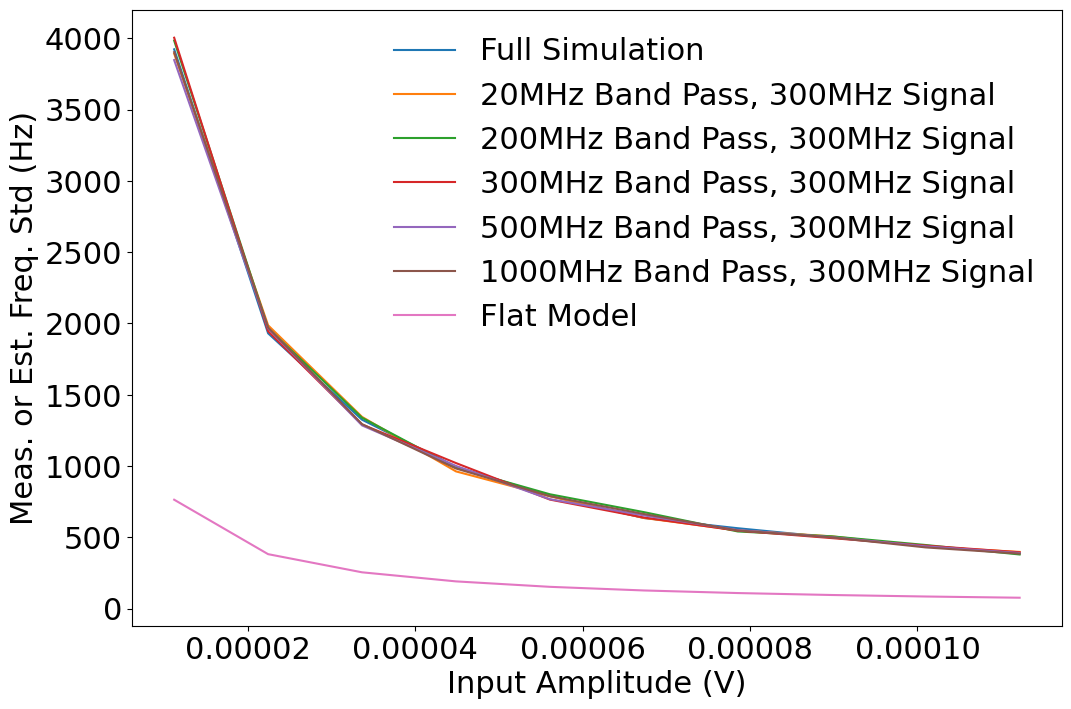

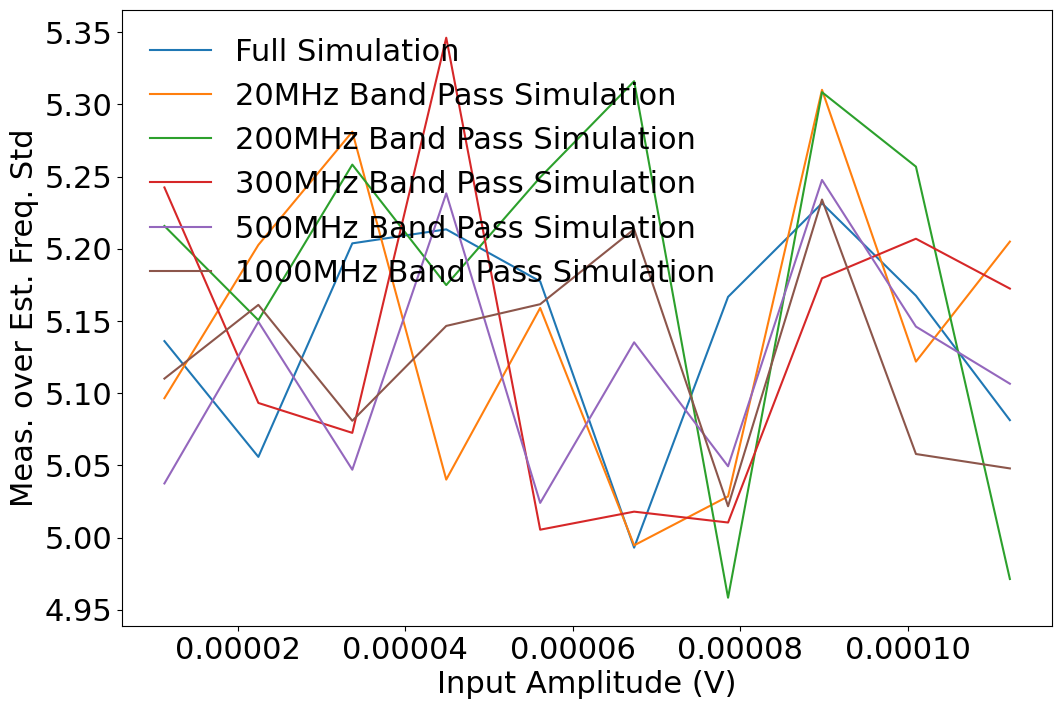

In [16]:

fig,ax = plt.subplots()
ax.plot(scaledAmpList,npsStdList,label="Full Simulation")
#ax.plot(scaledAmpList,bp2FreqStd,label="2MHz Band Pass, 300MHz Signal")
ax.plot(scaledAmpList,bp20FreqStd,label="20MHz Band Pass, 300MHz Signal")
ax.plot(scaledAmpList,bp200FreqStd,label="200MHz Band Pass, 300MHz Signal")
ax.plot(scaledAmpList,bp300FreqStd,label="300MHz Band Pass, 300MHz Signal")
#ax.plot(scaledAmpList,bp300FreqStd_250MHz,label="300MHz Band Pass, 250MHz Signal")
#ax.plot(scaledAmpList,bp500FreqStd_250MHz,label="500MHz Band Pass, 250MHz Signal")
#ax.plot(scaledAmpList,bp1000FreqStd_800MHz,label="1000MHz Band Pass, 800MHz Signal")
ax.plot(scaledAmpList,bp500FreqStd,label="500MHz Band Pass, 300MHz Signal")
ax.plot(scaledAmpList,bp1000FreqStd,label="1000MHz Band Pass, 300MHz Signal")
ax.plot(scaledAmpList,np.sqrt(getEstFreqVariance(snrp,samplingRate,obTime)),label='Flat Model')
ax.set_xlabel("Input Amplitude (V)")
ax.set_ylabel("Meas. or Est. Freq. Std (Hz)")
ax.legend()


fig,ax = plt.subplots()
ax.plot(scaledAmpList,npsStdList/np.sqrt(getEstFreqVariance(snrp,samplingRate,obTime)),label="Full Simulation")
#ax.plot(scaledAmpList,bp2FreqStd/np.sqrt(getEstFreqVariance(snrp,samplingRate,obTime)),label="2MHz Band Pass Simulation")
ax.plot(scaledAmpList,bp20FreqStd/np.sqrt(getEstFreqVariance(snrp,samplingRate,obTime)),label="20MHz Band Pass Simulation")
ax.plot(scaledAmpList,bp200FreqStd/np.sqrt(getEstFreqVariance(snrp,samplingRate,obTime)),label="200MHz Band Pass Simulation")
ax.plot(scaledAmpList,bp300FreqStd/np.sqrt(getEstFreqVariance(snrp,samplingRate,obTime)),label="300MHz Band Pass Simulation")
ax.plot(scaledAmpList,bp500FreqStd/np.sqrt(getEstFreqVariance(snrp,samplingRate,obTime)),label="500MHz Band Pass Simulation")
ax.plot(scaledAmpList,bp1000FreqStd/np.sqrt(getEstFreqVariance(snrp,samplingRate,obTime)),label="1000MHz Band Pass Simulation")
ax.set_xlabel("Input Amplitude (V)")
ax.set_ylabel("Meas. over Est. Freq. Std")
ax.legend()

In [22]:
def getNoisePowerAtFreq(t,gainNoise,thisFreq):
    xf = pft.getFrequencyBins(len(t),t[1]-t[0])
    powerVals=pft.getThermalNoisePower(xf,gainNoise,T=292,R=50)
    idx= find_nearest_index(xf,thisFreq)
    thisPower=powerVals[idx]
    return thisPower
    #noiseVals=irfft(rfftVals)
    #return noiseVals
noise2=generateNoise(t,gainBandPass2)
noise20=generateNoise(t,gainBandPass20)
noise200=generateNoise(t,gainBandPass200)
noise300=generateNoise(t,gainBandPass300)
noise500=generateNoise(t,gainBandPass500)
noise1000=generateNoise(t,gainBandPass1000)
gbpList=[gainBandPass2,gainBandPass20,gainBandPass200,gainBandPass300,gainBandPass500,gainBandPass1000]
noiseList=[noise2, noise20, noise200,noise300,noise500,noise1000]
bpAmpMeanList = [bp2AmpMean,bp20AmpMean,bp200AmpMean,bp300AmpMean,bp500AmpMean,bp1000AmpMean]
bpList = [2,20,200,300,500,1000]
for i in range(len(bpList)):
    noise=noiseList[i]
    noiseStd=np.std(noise)
    bpAmpMean=bpAmpMeanList[i]
    sinePower=np.array(bpAmpMean)**2 / 50
    thisPower=getNoisePowerAtFreq(t,gbpList[i],300e6)
    
    bp=bpList[i]
    #thisSnrp=np.array(bpAmpMean)**2 / (2*noiseStd**2)
    otherSnrp=sinePower/thisPower
    print("bandPass=",bp,thisPower,sinePower,otherSnrp)
    print("snrp",snrp)
    print("ratio",otherSnrp/snrp)

bandPass= 2 2.548863943334359e-07 [0.000199   0.0007956  0.00179128 0.00318558 0.00497652 0.00716464
 0.00975011 0.01274231 0.01611345 0.0198948 ] [  780.73730877  3121.39963332  7027.76757357 12498.05686295
 19524.45984293 28109.14175914 38252.75493113 49992.12546342
 63218.17197447 78053.58982049]
snrp [ 0.20845628  0.83382511  1.87610651  3.33530046  5.21140696  7.50442602
 10.21435764 13.34120182 16.88495855 20.84562784]
ratio [3745.32882667 3743.47040127 3745.93209446 3747.20569584 3746.4853519
 3745.67510809 3744.99858576 3747.19805122 3744.05254068 3744.36262613]
bandPass= 20 2.5488165379025297e-07 [0.00019902 0.00079636 0.00179142 0.00318194 0.00497898 0.00716152
 0.00974752 0.01273226 0.01611819 0.01991231] [  780.84274667  3124.41140468  7028.42910948 12483.99914869
 19534.49543217 28097.43207635 38243.3305609  49953.61336911
 63237.92828103 78123.74561078]
snrp [ 0.20845628  0.83382511  1.87610651  3.33530046  5.21140696  7.50442602
 10.21435764 13.34120182 16.88495855 20.84